In [25]:
# ! pip install traces

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import time

In [2]:
data = pd.read_csv('Coinbase_BTCUSD_ob_10_2019_09_01.csv.gz', compression='gzip',error_bad_lines=False)
print("The structure of the dataframe is as follows:")
data

The structure of the dataframe is as follows:


date type     price    amount
0         1567296016662    b   9600.85  0.058399
1         1567296016662    b   9600.01  0.225000
2         1567296016662    b   9600.00  0.104123
3         1567296016662    b   9600.00  0.021774
4         1567296016662    b   9600.00  1.000000
...                 ...  ...       ...       ...
31007929  1567382368048    a  10743.20  0.004840
31007930  1567382368048    a  10744.40  0.001000
31007931  1567382368048    a  10745.00  0.001000
31007932  1567382368048    a  10745.46  0.001000
31007933  1567382368048    a  10747.00  1.000000

[31007934 rows x 4 columns]

There are 2861 unique timestamps
The timestamp difference is not consistent and varies from: 24.839s to 60.088s




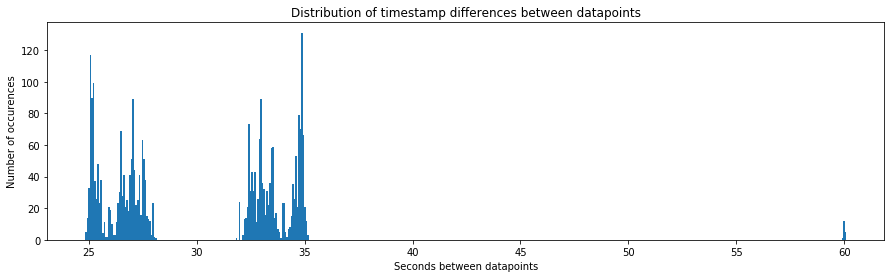

In [31]:
# Number of unique timestamps
print("There are {} unique timestamps".format(len(data['date'].unique())))

# Time difference between timestamps between entry points
a = [i for i,j in data.groupby("date")]
time_diff = np.diff(a) /1000
print("The timestamp difference is not consistent and varies from: {}s to {}s\n\n".format(time_diff.min(),time_diff.max()))
plt.figure(figsize=(15,4))
plt.hist(time_diff,500);
plt.title("Distribution of timestamp differences between datapoints")
plt.xlabel("Seconds between datapoints")
plt.ylabel("Number of occurences")
plt.show()

/Users/ranykhalil/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/ranykhalil/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date type     price    amount  bins
0      1567296016662    b   9600.85  0.058399  1053
1      1567296016662    b   9600.01  0.225000  1052
2      1567296016662    b   9600.00  0.104123  1052
3      1567296016662    b   9600.00  0.021774  1052
4      1567296016662    b   9600.00  1.000000  1052
...              ...  ...       ...       ...   ...
10691  1567296016662    a  10560.00  0.015917   952
10692  1567296016662    a  10560.00  1.000000   952
10693  1567296016662    a  10560.00  0.009500   952
10694  1567296016662    a  10560.00  0.001000   952
10695  1567296016662    a  10560.00  0.001000   952

[10696 rows x 5 columns]

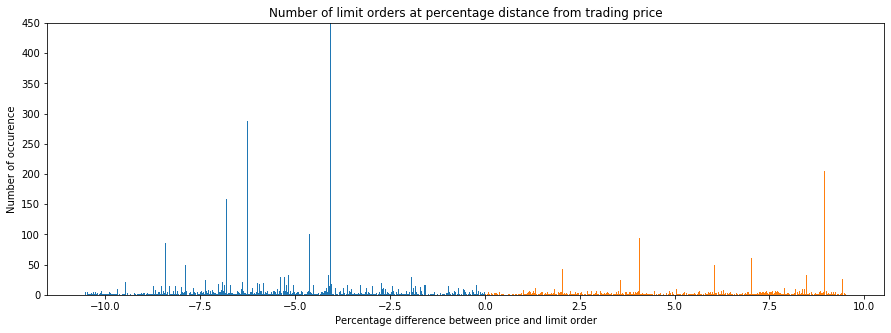

In [112]:
# Manual binning of bids for first timestamp test
data2 = data.loc[data['date'] == 1567296016662]
data3 = data2.loc[data2['type'] == 'b']
data4 = data2.loc[data2['type'] == 'a']
bid_bins = []
ask_bins = []
bin_stepsize = 0.01/100 # 0.01 percent

value1 = data3['price'].min()
value2 = data4['price'].min()
while value1 <=  data3['price'].max()*(1+bin_stepsize):
    bid_bins.append(value1)
    value1 = value1*(1+bin_stepsize)
labels = np.array(range(len(bid_bins)-1))
data3['bins'] = pd.cut(data3['price'],bid_bins,include_lowest=True,labels=labels)

while value2 <=  data4['price'].max()*(1+bin_stepsize):
    ask_bins.append(value2)
    value2 = value2*(1+bin_stepsize)
labels = np.array(range(len(ask_bins)-1))
data4['bins'] = pd.cut(data4['price'],ask_bins,include_lowest=True,labels=labels)


plt.figure(figsize=(15,5))
plt.hist(data3['bins'].map(lambda x: x*-0.01),data3['bins'].max()-100)
plt.hist(data4['bins'].map(lambda x: x*0.01),data4['bins'].max()-100)

plt.title("Number of limit orders at percentage distance from trading price")
plt.xlabel("Percentage difference between price and limit order")
plt.ylabel("Number of occurence")
plt.ylim(0,450)
data3 = pd.concat([data3,data4])
data3

In [114]:
import bisect

class RevTypeCompares(object):
     def __init__(self, value):
         self.value = value
     def __gt__(self, other):
         return self.value < other[0:len(self.value)]
     def __lt__(self, other):
         return self.value[0:len(self.value)] > other

# Creating binned df structure
def create_newdf(N):
    """This function creates an empty dataframe with N number of columns"""
    cols = ["date"]
    for i in range(0,N * 2):
       cols.append(str(i))

    newdf = pd.DataFrame(columns=cols)
    newdf.set_index("date",inplace=True)
    return cols, newdf

def add_columns_todf(df,n):
    """This function adds n number of columns to an existing dataframe df"""
    columns = ['date']
    for i in range(int(newdf.columns[-1]),int(newdf.columns[-1])+1+ n):
        columns.append(str(i))
    add = pd.DataFrame(columns=columns)

    add.set_index("date",inplace=True)

    result = pd.concat([df, add], axis=1, sort=False)
    result.fillna(0,inplace=True)
    return result    

def find_mid_price(i):
    idx = bisect.bisect_left(list(i['type'].values), RevTypeCompares('a'))
    low = i['price'].values[0]
    high = i['price'].values[idx]

    return (low + high )/2

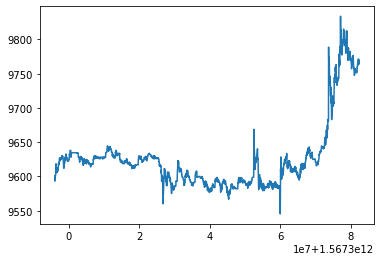

In [115]:
# Plotting the prices over the 24hr period
prices = []
for date, i in data.groupby("date"):
    mid_price =  find_mid_price(i)
    prices.append(round(mid_price,3))
    
# print('max:',max(prices),'min:',min(prices))
plt.plot(data['date'].unique(),prices)

In [155]:
pd.Series(prices).min()*0.9
pd.Series(prices).max()*1.1

8590.824

In [117]:
newdf = pd.read_csv('binned_data_24hrs.csv')

In [148]:

prices_pct = pd.Series(prices).map(lambda x:((x-prices[0])/prices[0])*100)/0.01
prices_pct = round(prices_pct - prices_pct.min()).map(lambda x:int(x))
push_df = pd.DataFrame()
push_df['date']=newdf.index
push_df['push']=prices_pct 
push_df = push_df.set_index('date')

push_df

push    301
dtype: int64

In [121]:
edited_df = add_columns_todf(newdf,push_df['push'].max())

In [123]:
edited_df = edited_df.apply(lambda x: x.shift(periods=push_df.loc[x.name]['push'],fill_value=0),axis=1)
edited_df.T.iloc[::-1]



0     1     2     3     4     5     6     7     8     9     ...  \
2300   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2299   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2298   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2297   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2296   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
date   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

          2851      2852      2853      2854      2855      2856      2857  \
2300  0.000000  0.801000  0.000000  0.192748  0.031429  0.636477  0.636477   
2299  1.818413  0.001001  0.000000  0.200000  1.786985  1.024000  1.024000   
2298  0.000000  1.001764  0.301000  1.459477  0.000000  0.029396  0.029396   
2297  0.000000  0.000000  0.501001  0.011112  0.000000  0.001472  0.001472   
2296  0.801000  0.002000  1.001764  0.020757  0.801000  1.818413  1.818413   
...        ...       ...       ...       ...       ...       ...       ...   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
date  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          2858      2859      2860  
2300  0.636477  1.786985  0.000000  
2299  1.023000  0.000000  0.000000  
2298  0.030396  0.000000  0.301000  
2297  0.001472  0.801000  0.501001  
2296  1.818413  0.001001  1.001764  
...        ...       ...       ...  
3     0.000000  0.000000  0.000000  
2     0.000000  0.000000  0.000000  
1     0.000000  0.000000  0.000000  
0     0.000000  0.000000  0.000000  
date  0.000000  0.000000  0.000000  

[2303 rows x 2861 columns]

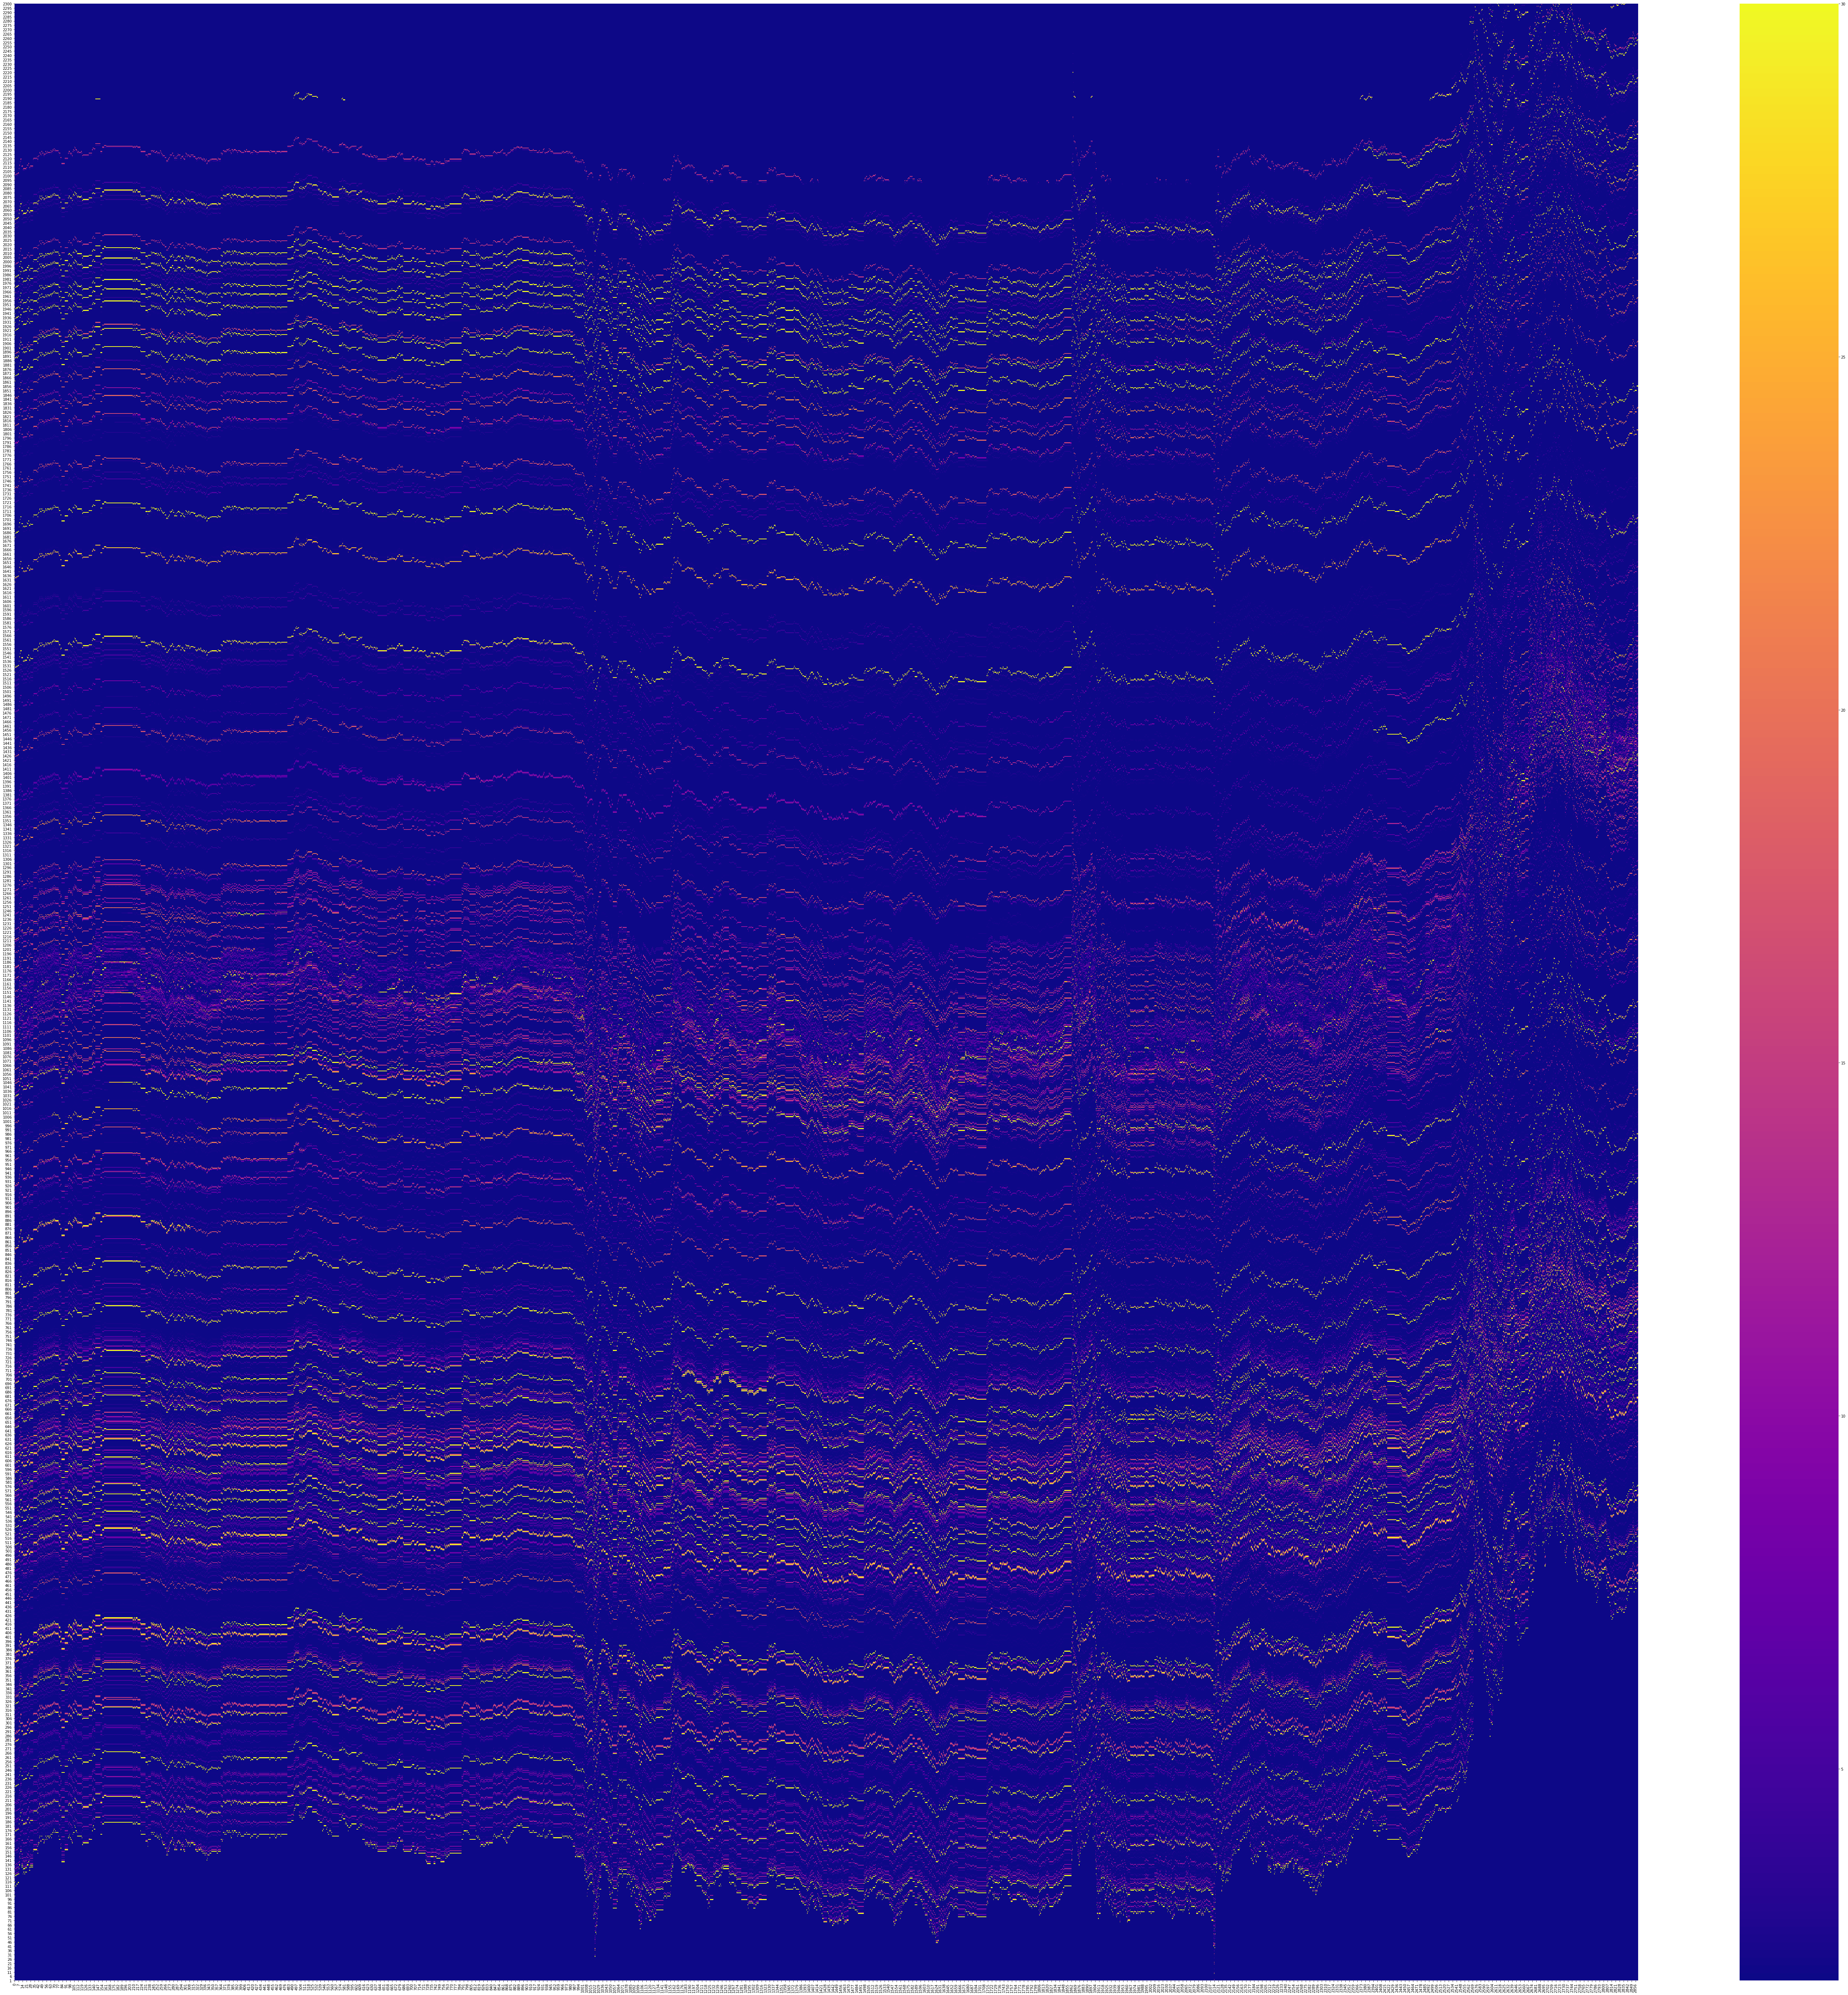

In [126]:
plt.figure(figsize=(100,100))
vmin=2
vmax=30
sns.heatmap(edited_df.T.iloc[::-1],cmap="plasma",vmin=vmin, vmax=vmax)

In [127]:
price_push = push_df[["push"]]+1000-push_df["push"][push_df.index.min()]

price_push.T

date  0     1     2     3     4     5     6     7     8     9     ...  2851  \
push  1000   992   998   998   999   999  1000  1000  1005  1010  ...  1174   

date  2852  2853  2854  2855  2856  2857  2858  2859  2860  
push  1178  1176  1169  1174  1171  1171  1171  1175  1176  

[1 rows x 2861 columns]

In [128]:
edited_df.T.iloc[::-1]
# make price mid a column perctange change shifted up and run linear rea

0     1     2     3     4     5     6     7     8     9     ...  \
2300   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2299   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2298   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2297   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2296   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
date   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

          2851      2852      2853      2854      2855      2856      2857  \
2300  0.000000  0.801000  0.000000  0.192748  0.031429  0.636477  0.636477   
2299  1.818413  0.001001  0.000000  0.200000  1.786985  1.024000  1.024000   
2298  0.000000  1.001764  0.301000  1.459477  0.000000  0.029396  0.029396   
2297  0.000000  0.000000  0.501001  0.011112  0.000000  0.001472  0.001472   
2296  0.801000  0.002000  1.001764  0.020757  0.801000  1.818413  1.818413   
...        ...       ...       ...       ...       ...       ...       ...   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
date  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          2858      2859      2860  
2300  0.636477  1.786985  0.000000  
2299  1.023000  0.000000  0.000000  
2298  0.030396  0.000000  0.301000  
2297  0.001472  0.801000  0.501001  
2296  1.818413  0.001001  1.001764  
...        ...       ...       ...  
3     0.000000  0.000000  0.000000  
2     0.000000  0.000000  0.000000  
1     0.000000  0.000000  0.000000  
0     0.000000  0.000000  0.000000  
date  0.000000  0.000000  0.000000  

[2303 rows x 2861 columns]

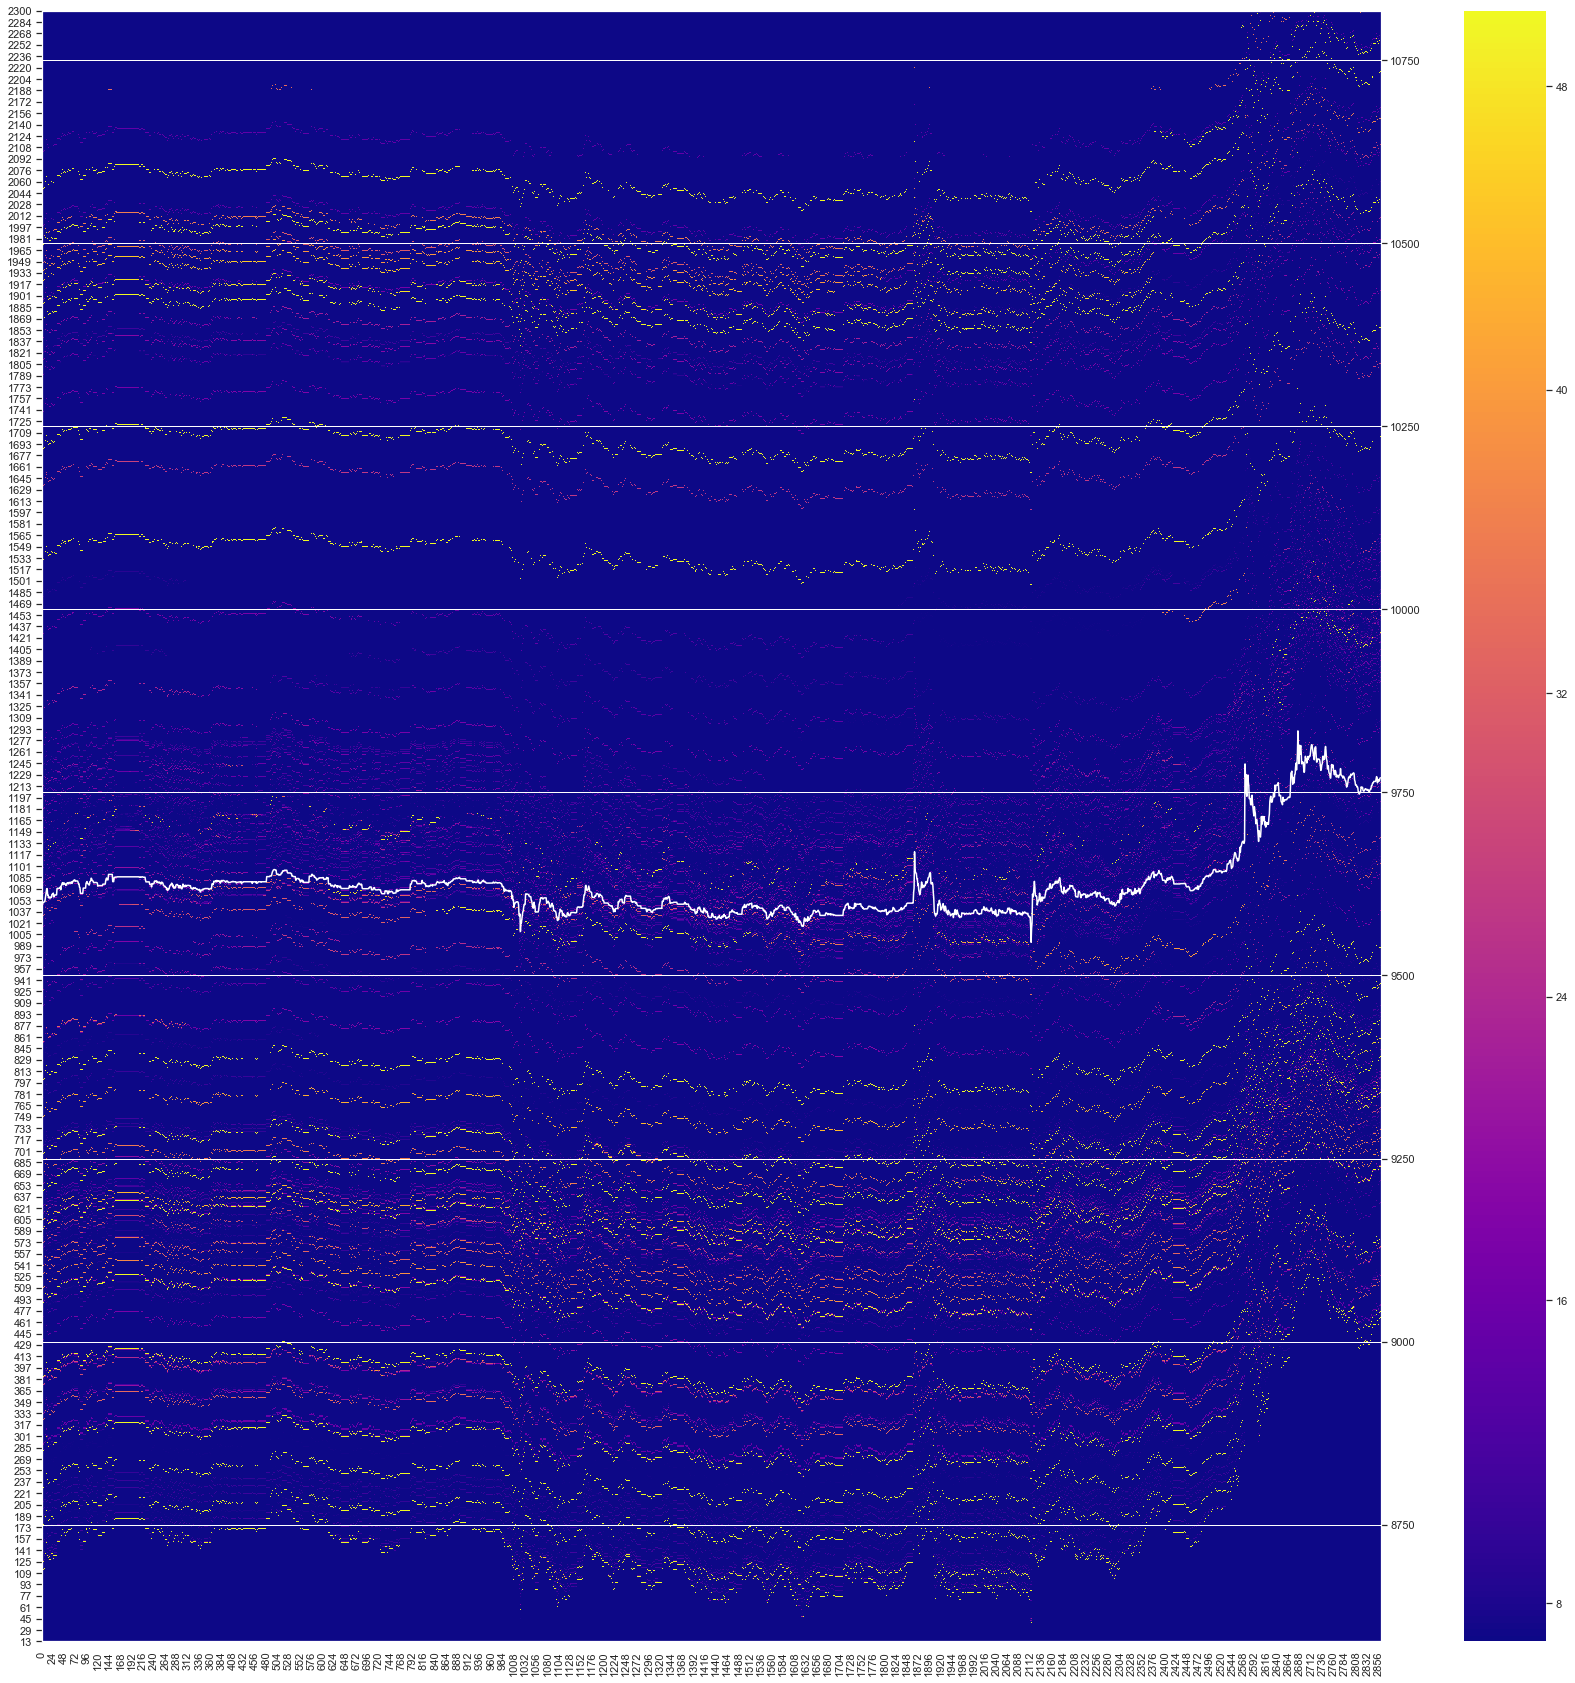

In [168]:
fig, ax1 = plt.subplots(figsize=(30,30))
ax2 = ax1.twinx()
sns.heatmap(edited_df.T.iloc[::-1],vmin=7, vmax=50,cmap="plasma",ax=ax1)
price_push = push_df["push"]+1000#-push_df["push"][push_df.index.min()]
# price_push = push_df[["push"]]+1000-push_df["push"][push_df.index.min()]
# sns.lineplot(data['date'].unique(),price_push,color="black",linewidth=5, ax=ax1)

# sns.scatterplot(data['date'].unique(),price_push,color="black", ax=ax1)
ax2.set_ylim([pd.Series(prices).min()*0.9, pd.Series(prices).max()*1.1]) 
sns.lineplot(range(0,len(data['date'].unique())),prices,color="white",ax=ax2)



plt.show()
sns.set()

In [ ]:
# Linear regression on returns

In [8]:
N = 1000
cols, newdf = create_newdf(N)

start = time.time()
def time_checkpoint(n):
    global start
    diff = time.time() - start
    start = time.time()
    print(n, ":", diff)

for date, i in data.groupby("date"):
    mid_price =  find_mid_price(i)
    low = mid_price * 0.9
    high = mid_price * 1.1
    
    next_row = list(np.zeros(N * 2))
        
    for ii, j in i.iterrows():
        b = math.floor( (j["price"] - low ) / ( high - low  ) * N * 2 )
        if b >= 2 * N or b < 0:
#             print("out of range", b, j["price"], "low", low, "high", high)
            continue
        next_row[b] += j["amount"]
    newdf.loc[date] = pd.Series([date] + next_row, index=cols)
    time_checkpoint(date)

newdf.to_csv('binned_data_24hrs.csv',header=True)



1567296016662 : 2.8858048915863037
1567296049570 : 1.197340965270996
1567296076678 : 1.125756025314331
1567296109569 : 1.156317949295044
1567296136677 : 1.1168901920318604
1567296169574 : 1.1364407539367676
1567296196712 : 1.1456680297851562
1567296229569 : 1.1392667293548584
1567296256690 : 1.1287784576416016
1567296289569 : 1.1183927059173584
1567296316691 : 1.1133601665496826
1567296349568 : 1.2284209728240967
1567296376705 : 1.2850289344787598
1567296409569 : 1.169344186782837
1567296436708 : 1.166975975036621
1567296469569 : 1.3700101375579834
1567296496705 : 1.5042839050292969
1567296529593 : 2.5458991527557373
1567296556757 : 1.4568397998809814
1567296589569 : 1.2405128479003906
1567296616765 : 1.3174238204956055
1567296649569 : 1.2093451023101807
1567296676759 : 1.3874361515045166
1567296709569 : 1.1526598930358887
1567296736758 : 1.1483681201934814
1567296769569 : 1.1649279594421387
1567296796757 : 1.196498155593872
1567296829569 : 1.2019290924072266
1567296856886 : 1.17125678

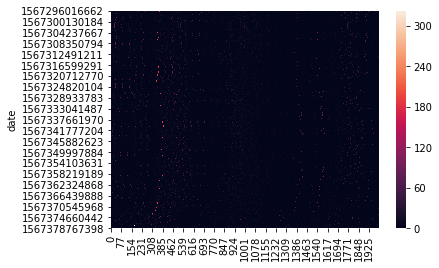

In [12]:
import seaborn as sns
sns.heatmap(newdf)

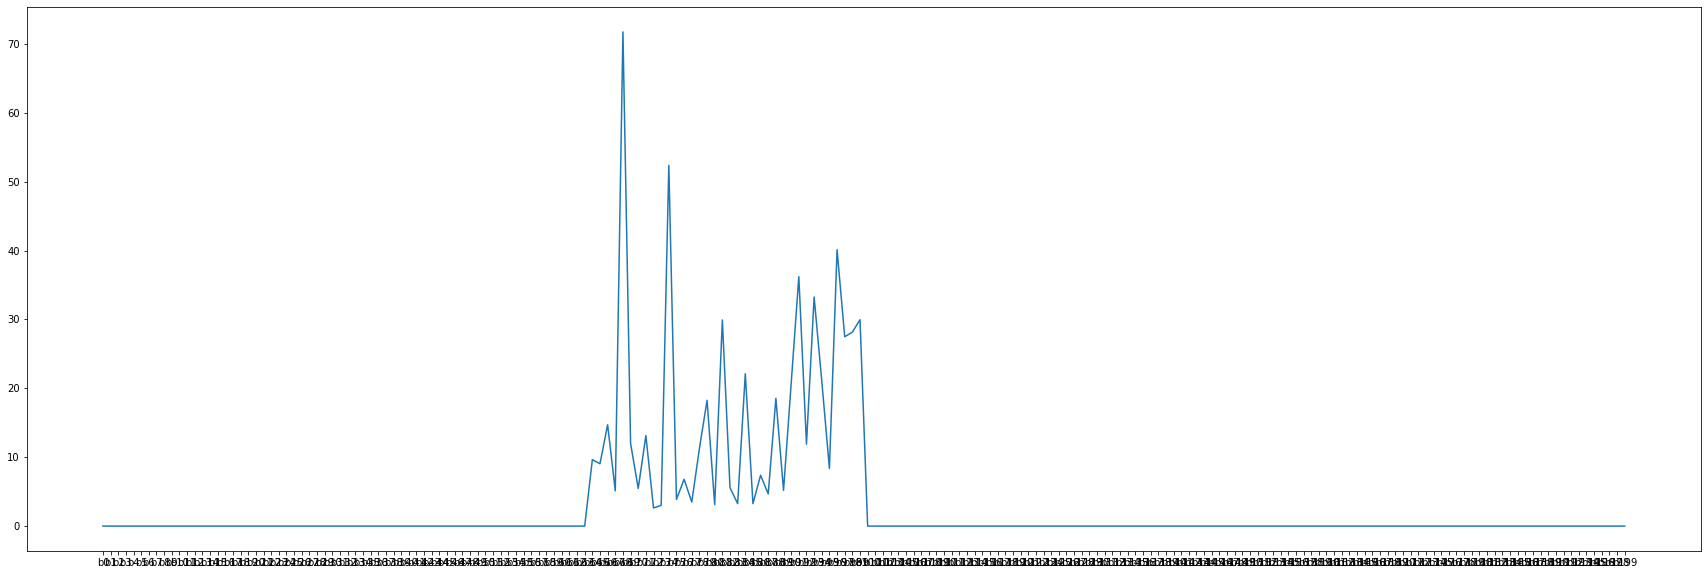

In [296]:
plt.figure(figsize=(30,10))
plt.plot(cols[1:],newdf.loc[newdf.index == date].values[0])
# newdf.loc[newdf.index == date].values[0][:100].sum()


TypeError: '<=' not supported between instances of 'int' and 'str'

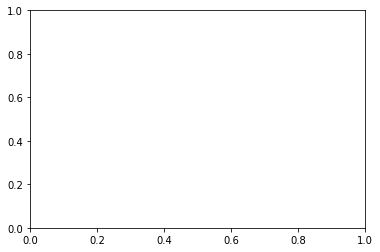

In [8]:
plt.hist(data3,100)

In [84]:
data3

price
0     9600.85
1     9600.01
2     9600.00
3     9600.00
4     9600.00
...       ...
7849  8643.00
7850  8642.00
7851  8642.00
7852  8641.95
7853  8641.00

[7854 rows x 1 columns]

[  90.   58.   39.   42.   35.   32.  258.   52.   49.   36.   31.  183.
   49.   29.   45.   41.  341.   75.   52.   38.   36.   88.   59.   34.
   52.  133.  252.   51.   51.   41.   35.   35.   98.   34.   50.   38.
   72. 1009.  103.   57.   63.   43.  149.   70.   50.   73.   66.  365.
  121.   91.   79.   66.   35.  159.   44.   69.   61.   43.  363.   90.
   65.   61.   46.  198.   52.   44.   70.   57.  288.   63.   57.   47.
   39.   71.   41.   25.   39.   27.   28.  117.   28.   29.   27.   21.
   31.   17.   11.   14.   15.   28.   17.   21.   12.   13.   18.   20.
   26.   22.   30.   16.] [8641.     8650.5985 8660.197  8669.7955 8679.394  8688.9925 8698.591
 8708.1895 8717.788  8727.3865 8736.985  8746.5835 8756.182  8765.7805
 8775.379  8784.9775 8794.576  8804.1745 8813.773  8823.3715 8832.97
 8842.5685 8852.167  8861.7655 8871.364  8880.9625 8890.561  8900.1595
 8909.758  8919.3565 8928.955  8938.5535 8948.152  8957.7505 8967.349
 8976.9475 8986.546  8996.1445 9005.743

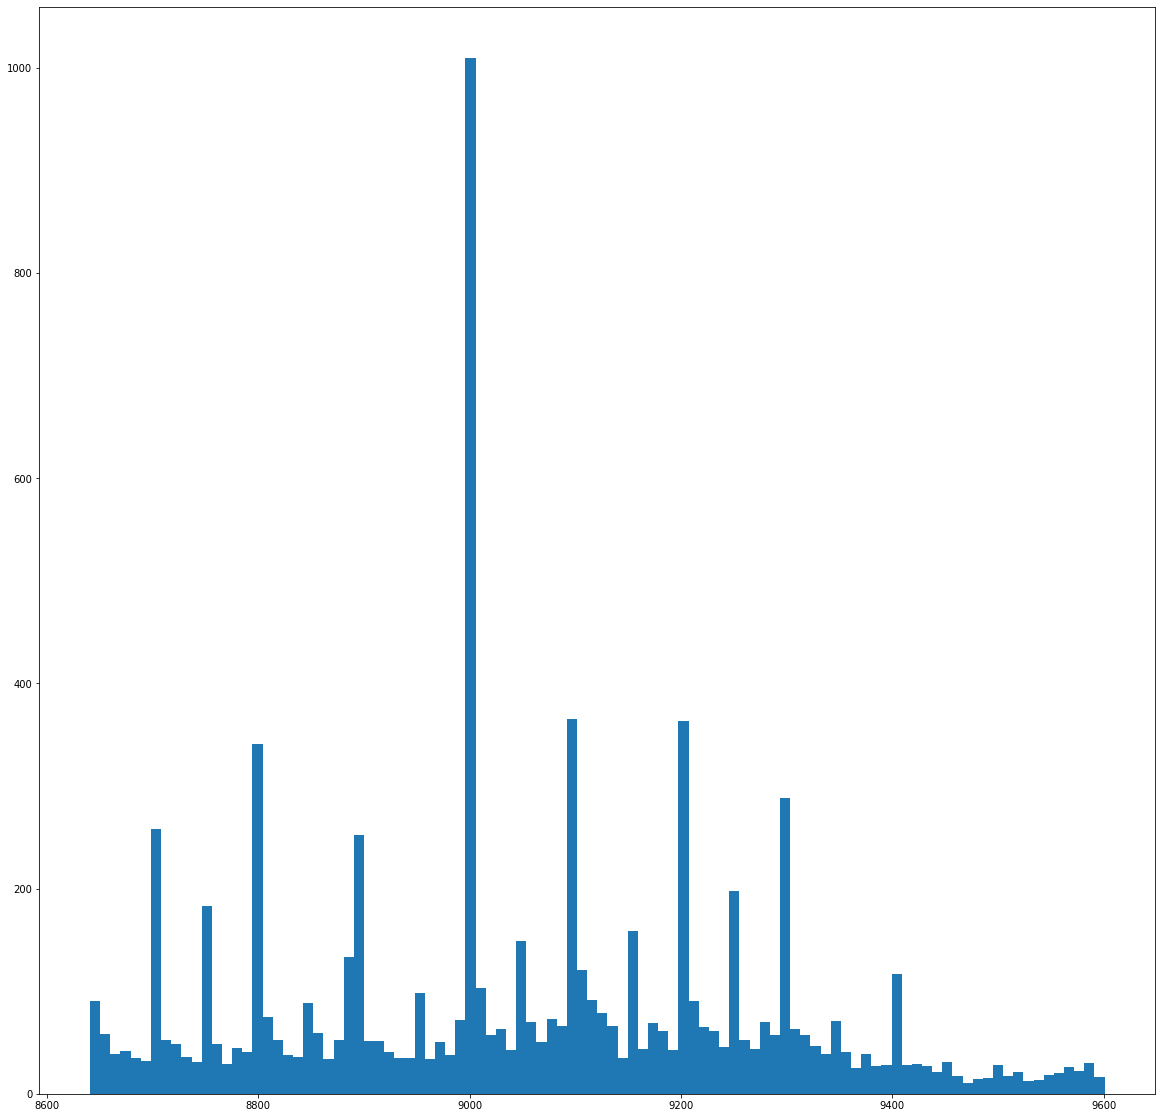

In [67]:
data3
plt.figure(figsize=(20,20))
n,bins,patches = plt.hist(data3['price'],100)
print(n, bins,patches)

In [50]:
data4

date type     price    amount          cost
7854   1567296016662    a   9600.86  0.295767   2839.618232
7855   1567296016662    a   9600.86  0.002000     19.201720
7856   1567296016662    a   9600.86  0.315649   3030.505026
7857   1567296016662    a   9600.86  2.500000  24002.150000
7858   1567296016662    a   9600.86  0.031751    304.838634
...              ...  ...       ...       ...           ...
10691  1567296016662    a  10560.00  0.015917    168.084154
10692  1567296016662    a  10560.00  1.000000  10560.000000
10693  1567296016662    a  10560.00  0.009500    100.320000
10694  1567296016662    a  10560.00  0.001000     10.560000
10695  1567296016662    a  10560.00  0.001000     10.560000

[2842 rows x 5 columns]

In [18]:
data.loc[(data['date'] == 1567296016662)& (data['type'] == 'a')]

date type     price    amount          cost
7854   1567296016662    a   9600.86  0.295767   2839.618232
7855   1567296016662    a   9600.86  0.002000     19.201720
7856   1567296016662    a   9600.86  0.315649   3030.505026
7857   1567296016662    a   9600.86  2.500000  24002.150000
7858   1567296016662    a   9600.86  0.031751    304.838634
...              ...  ...       ...       ...           ...
10691  1567296016662    a  10560.00  0.015917    168.084154
10692  1567296016662    a  10560.00  1.000000  10560.000000
10693  1567296016662    a  10560.00  0.009500    100.320000
10694  1567296016662    a  10560.00  0.001000     10.560000
10695  1567296016662    a  10560.00  0.001000     10.560000

[2842 rows x 5 columns]

(0.0, 10)

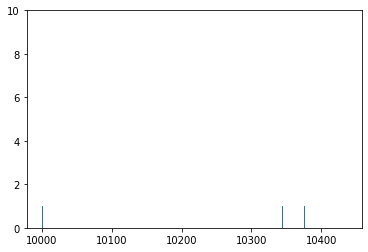

In [51]:
# plt.hist(data.loc[(data['date'] == 1567296016662)& (data['type'] == 'a'),'price'],600);
plt.hist(data.loc[(data['date'] == 1567296016662)& (data['type'] == 'a')& (data['amount'] > 20),'price'],600);


plt.ylim(top=10)

In [39]:
1567296049570 - 1567296016662
data.loc[(data['date'] > 1567296049570)]

date type     price    amount          cost
21386     1567296076678    b   9598.19  0.655802   6294.515654
21387     1567296076678    b   9598.18  2.770000  26586.958600
21388     1567296076678    b   9598.16  0.001000      9.598160
21389     1567296076678    b   9598.15  0.750000   7198.612500
21390     1567296076678    b   9598.09  0.176702   1695.999972
...                 ...  ...       ...       ...           ...
31007929  1567382368048    a  10743.20  0.004840     51.999989
31007930  1567382368048    a  10744.40  0.001000     10.744400
31007931  1567382368048    a  10745.00  0.001000     10.745000
31007932  1567382368048    a  10745.46  0.001000     10.745460
31007933  1567382368048    a  10747.00  1.000000  10747.000000

[30986548 rows x 5 columns]

(0.0, 10)

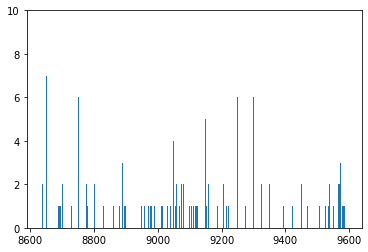

In [61]:
# plt.hist(data.loc[(data['date'] == 1567296049570)& (data['type'] == 'a'),'price'],600);
plt.hist(data.loc[(data['date'] == 1567296049570)& (data['type'] == 'b')& (data['amount'] > 2),'price'],600);

plt.ylim(top=10)

(0.0, 10)

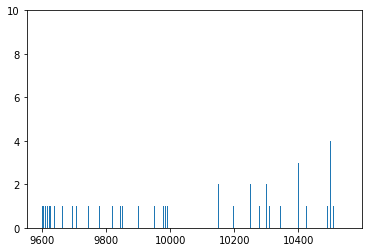

In [59]:
plt.hist(data.loc[(data['date'] == 1567296076678)& (data['type'] == 'a')& (data['amount'] > 2),'price'],600);
plt.ylim(top=10)

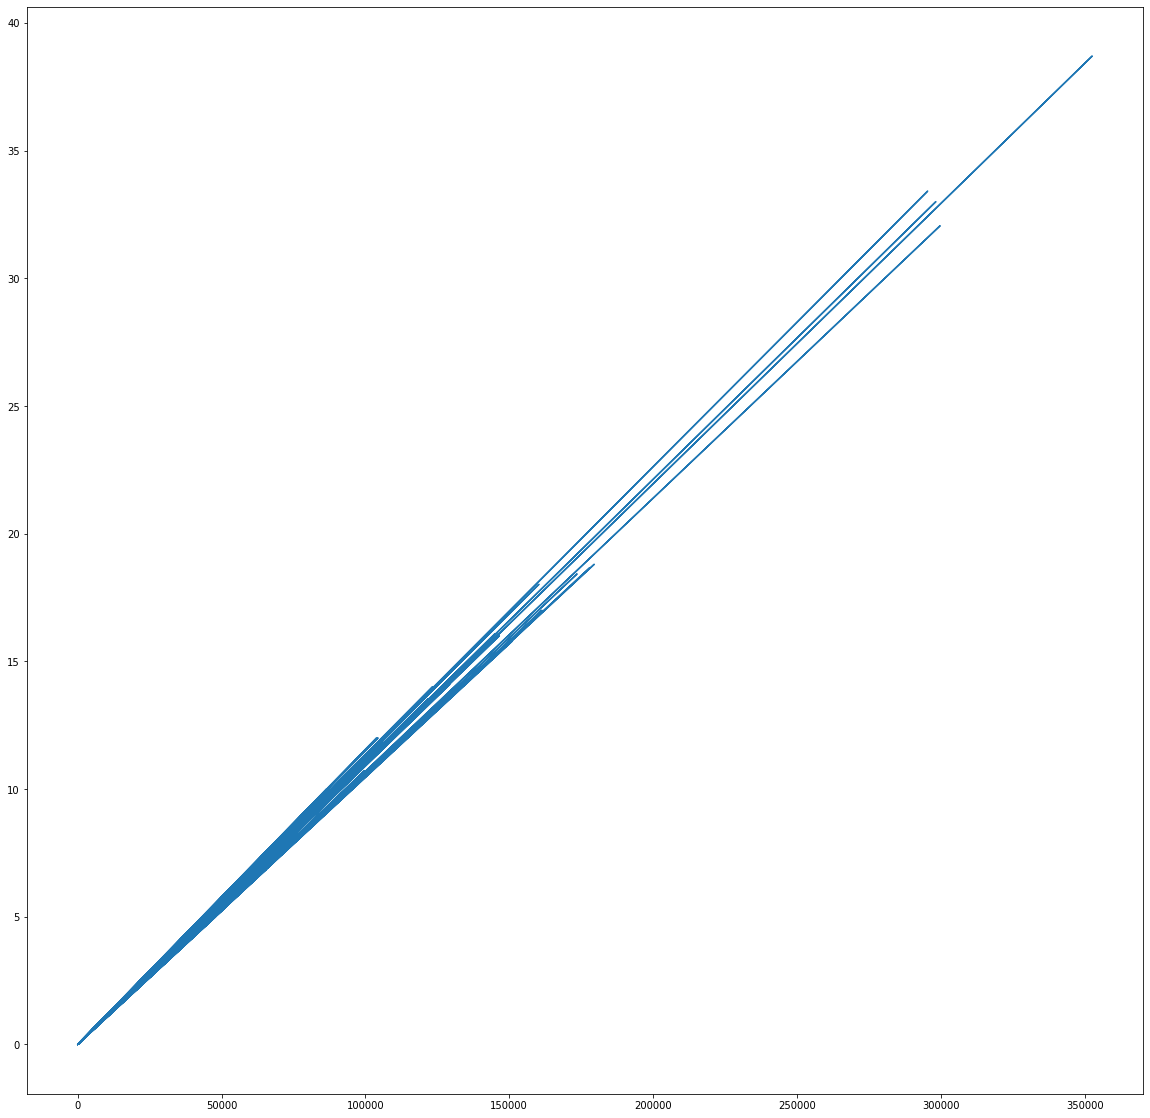

In [70]:
plt.plot(data.loc[(data['date'] == 1567296076678)& (data['type'] == 'b'),'cost'],data.loc[(data['date'] == 1567296076678)& (data['type'] == 'b'),'amount']);


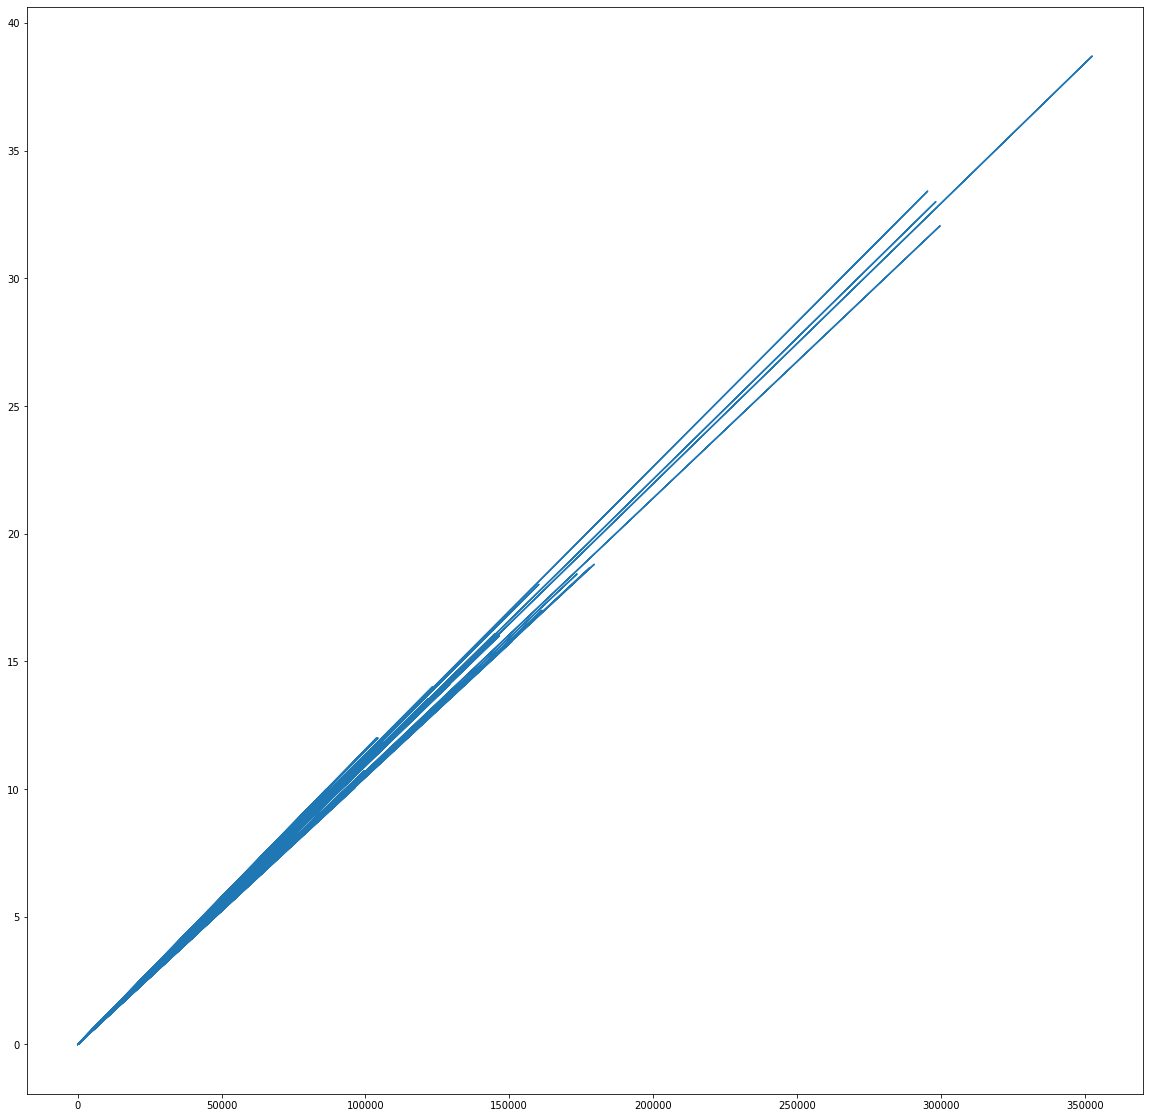

In [71]:
plt.figure(figsize=(20,20))
plt.plot(data.loc[(data['date'] == 1567296016662)& (data['type'] == 'b'),'cost'],data.loc[(data['date'] == 1567296016662)& (data['type'] == 'b'),'amount']);


In [20]:
data.loc[(data['date'] == 1567296016662)& (data['type'] == 'b')].max()

date      1567296016662
type                  b
price           9600.85
amount          38.7017
cost             352628
dtype: object

In [21]:
data.loc[(data['date'] == 1567296016662)& (data['type'] == 'b')]

date type    price    amount         cost
0     1567296016662    b  9600.85  0.058399   560.678599
1     1567296016662    b  9600.01  0.225000  2160.002250
2     1567296016662    b  9600.00  0.104123   999.581376
3     1567296016662    b  9600.00  0.021774   209.032128
4     1567296016662    b  9600.00  1.000000  9600.000000
...             ...  ...      ...       ...          ...
7849  1567296016662    b  8643.00  0.025000   216.075000
7850  1567296016662    b  8642.00  0.039534   341.649976
7851  1567296016662    b  8642.00  0.023109   199.707978
7852  1567296016662    b  8641.95  0.023000   198.764850
7853  1567296016662    b  8641.00  0.150000  1296.150000

[7854 rows x 5 columns]